# Prepare Required Files and Dependencies

Full dataset is available at [https://ritsumei365-my.sharepoint.com/:u:/g/personal/gr0609fv_ed_ritsumei_ac_jp/EYS6Pu3_90ZLv9To2RgpEioBjpGQjUTMlks6IdPfT4ZlEA?e=kVuEfg](https://ritsumei365-my.sharepoint.com/:u:/g/personal/gr0609fv_ed_ritsumei_ac_jp/EYS6Pu3_90ZLv9To2RgpEioBjpGQjUTMlks6IdPfT4ZlEA?e=kVuEfg)

In [1]:
!git clone https://github.com/dmc27/missing_pixels.git

fatal: destination path 'missing_pixels' already exists and is not an empty directory.


In [2]:
from os import listdir
from os.path import isfile
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import ModelCheckpoint

from utils import *

In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

random.seed(42)

# Data Preparation

In [4]:
img_path = "datasets"
img_fnames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
img_fnames = random.choices(img_fnames, k=1000)
print(img_fnames[:20])

['3527b667-4423-4fa5-bbdc-87857dd370f2.JPEG', '4cff3be4-dded-4b0a-97e8-abc0a3a964bf.JPEG', '42bf257b-e7eb-4c92-8774-1a7556282f4b.JPEG', '0580aed6-0069-4931-a9ab-af0c500c19a6.JPEG', 'bc88044b-adab-4f66-a5a4-b8b05dc83df2.JPEG', '5360e0a5-b441-4ba1-9565-8abda2ed3c9c.JPEG', '9db5086c-bbf0-46ea-8029-728f64291d39.JPEG', '166e1c7d-8008-435b-b9f0-90a684f3732e.JPEG', '6a18e5cd-3498-46f7-9c8a-b4011e1792d4.JPEG', 'a33c2a76-043f-4d2a-b18e-215626038746.JPEG', 'ed4123a4-ec53-49c2-adf4-7e125b6f0056.JPEG', '63f3f0d4-1554-49b7-a52b-896a300b484c.JPEG', '32cef872-6eb1-4295-abc1-4ab169284d5d.JPEG', '0bec73d2-61f9-4c15-bb18-fc8755201a71.JPEG', '7ea64000-424c-4063-8987-19450c42aec1.JPEG', '4d237abb-f780-442e-8d91-b26b8caa2fcd.JPEG', 'cfaf801e-6f3f-45de-880e-8b81c7190477.JPEG', '637a54ef-72ea-4e68-8339-05379bbc37be.JPEG', '871440c1-b10c-4afa-a4ed-8951b7e39b03.JPEG', 'f30572b2-5c1a-4a0a-bf4e-23b22bb2aeba.JPEG']


In [5]:
inputs = []
targets = []
for img_fname in img_fnames:
    img = cv.imread(join(img_path, img_fname), cv.IMREAD_GRAYSCALE)
    img = img.astype(np.float64)

    do_parse_img(img, inputs, targets)

X_train = np.zeros((len(inputs), NUM_INP_NODES))
y_train = np.zeros((len(targets), NUM_OUT_NODES))
for idx in range(len(inputs)):
    X_train[idx, :] = inputs[idx]
    y_train[idx] = targets[idx]

In [6]:
print(X_train.shape)

(64000, 60)


# Modeling

In [7]:
model_fname = "models/model.mlp.large.imagenet.h5"

model = Sequential([
    Dense(256, input_shape=(NUM_INP_NODES,), activation="relu"),
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    Dense(NUM_OUT_NODES, activation='sigmoid')
])

model.compile(loss="mean_squared_error", optimizer="adam",
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               15616     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                                 
Total params: 73540 (287.27 KB)
Trainable params: 73540 (287.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-07-20 16:49:40.256375: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-07-20 16:49:40.256393: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-07-20 16:49:40.256403: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-07-20 16:49:40.256434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-20 16:49:40.256451: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1,
                             save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=450, batch_size=512,
                    validation_split=0.1, callbacks=callbacks_list)

Epoch 1/450


2023-07-20 16:49:40.539488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.3385
Epoch 1: loss improved from inf to 0.02422, saving model to models/model.mlp.large.imagenet.h5
113/113 [==============================] - 1s 7ms/step - loss: 0.0242 - accuracy: 0.3385 - val_loss: 0.0126 - val_accuracy: 0.3667
Epoch 2/450
 12/113 [==>...........................] - ETA: 0s - loss: 0.0126 - accuracy: 0.3586

2023-07-20 16:49:41.469182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


109/113 [===========================>..] - ETA: 0s - loss: 0.0155 - accuracy: 0.3475
Epoch 2: loss improved from 0.02422 to 0.01608, saving model to models/model.mlp.large.imagenet.h5
113/113 [==============================] - 1s 5ms/step - loss: 0.0161 - accuracy: 0.3456 - val_loss: 0.0323 - val_accuracy: 0.2886
Epoch 3/450
111/113 [============================>.] - ETA: 0s - loss: 0.0294 - accuracy: 0.3272
Epoch 3: loss did not improve from 0.01608
113/113 [==============================] - 1s 5ms/step - loss: 0.0293 - accuracy: 0.3268 - val_loss: 0.0188 - val_accuracy: 0.3258
Epoch 4/450
111/113 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.3145
Epoch 4: loss did not improve from 0.01608
113/113 [==============================] - 1s 5ms/step - loss: 0.0181 - accuracy: 0.3156 - val_loss: 0.0221 - val_accuracy: 0.3355
Epoch 5/450
111/113 [============================>.] - ETA: 0s - loss: 0.0296 - accuracy: 0.3200
Epoch 5: loss did not improve from 0.01608
113

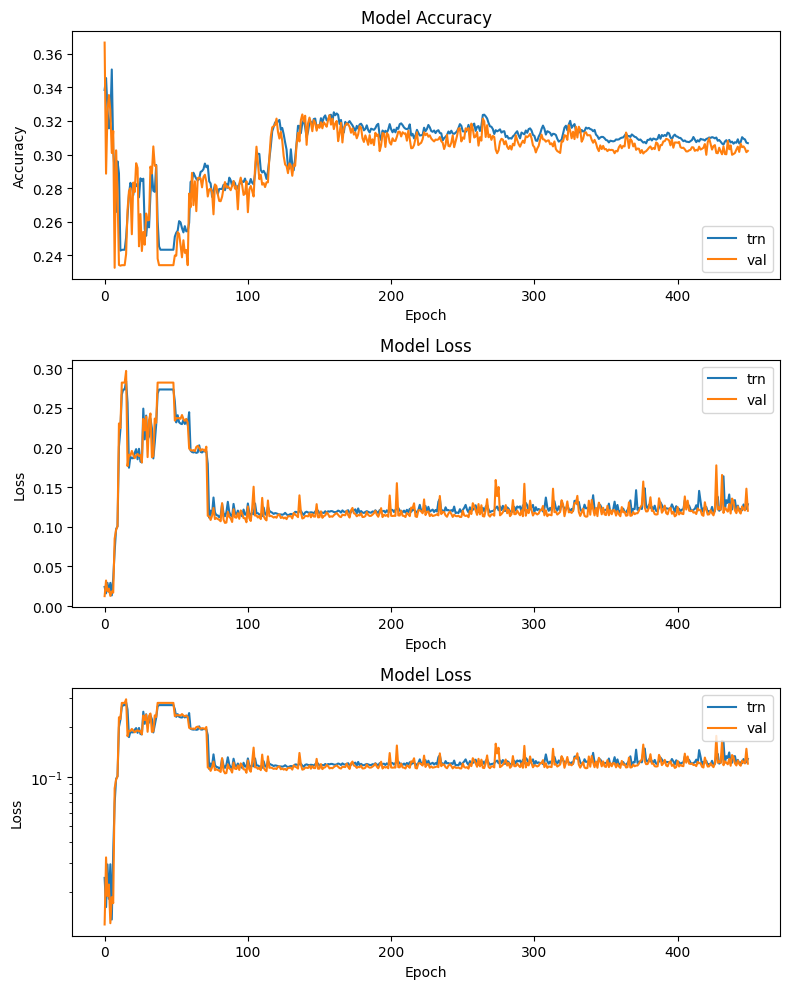

In [9]:
plot_training_history(history)

# Evaluation

32/32 [==============================] - 0s 1ms/step
MSE = 296.92


2023-07-20 16:53:57.805651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


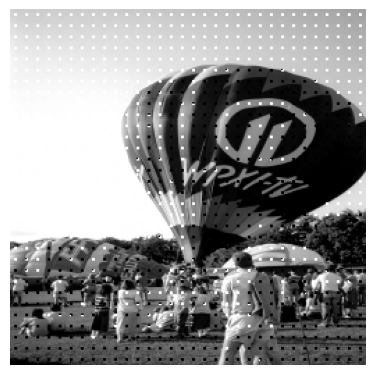

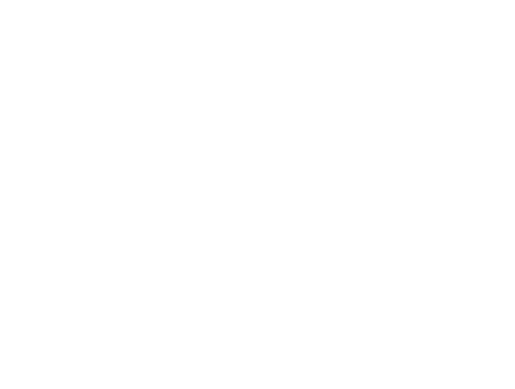

In [10]:
evaluate_mlp(model)